In [2]:
import sys

sys.path.append("../../")
sys.path.append("../../src")

In [3]:
# For the notebook to work you must have m3_learning installed
# pip install m3_learning
%load_ext autoreload
%autoreload 2

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.util.file_IO import download_and_unzip
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from IPython.display import Video

import json
import logging

import torch
import torch.nn.functional as F


# from m3_learning.be.dataset import BE_Dataset
printing = printer(basepath = './Figures/')

set_style("printing")
random_seed(seed=42)

%matplotlib inline


2024-08-14 11:46:23.667677: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 11:46:23.667711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 11:46:23.669851: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 11:46:23.681604: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 11:46:24.523493: W tensorflow/compiler/tf2

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [4]:
import sys

sys.path.append("../../")
# sys.path.append("/home/ferroelectric/Documents/m3_learning/m3_learning/src")
sys.path.append('../../src')

## Loading data for SHO fitting


In [5]:
# Download the data file from Zenodo
url = 'https://zenodo.org/record/7774788/files/PZT_2080_raw_data.h5?download=1'

# Specify the filename and the path to save the file
filename = '/data_raw_unmod.h5'
save_path = './Data'

# download the file
download_and_unzip(filename, url, save_path)

Using files already downloaded


In [5]:
data_path = save_path + '/' + filename

# instantiate the dataset object
dataset = BE_Dataset(data_path)

# print the contents of the file
dataset.print_be_tree()

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data-SHO_Fit_000/Spectroscopic_Values


/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/../../src/m3_learning/util/preprocessing.py:43: RuntimeWarning: invalid value encountered in divide
  return (data - self.mean)/self.std


/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Noisy_Data_1
    ├ Noisy_Data_2
    ├ Noisy_Data_3
    ├ Noisy_Data_4
    ├ Noisy_Data_5
    ├ Noisy_Data_6
    ├ Noisy_Data_7
    ├ Noisy_Data_8
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
├ Noisy_Data_1_SHO_Fit
  --------

In [6]:
import json
import os
import re
import csv
from m3_learning.nn.Fitter1D.Fitter1D import Multiscale1DFitter, Model
from m3_learning.nn.Fitter1D.Fitter1D import ComplexPostProcessor
from m3_learning.be.nn import SHO_fit_func_nn
import pandas as pd
from datafed.CommandLib import API


def search_for_alias(listing_reply, target_alias):
    """
    Searches for an item with a matching alias within a ListingReply.

    Parameters:
    - listing_reply: SDMS_Auth_pb2.ListingReply object containing the items to search through.
    - target_alias: String representing the alias to search for.

    Returns:
    - The matching item if found, otherwise None.
    """
    for item in listing_reply.item:
        if item.alias == target_alias:  # Assuming each item has an 'alias' field
            return item.id  # Return the matching item
    return None  # Return None if no match is found

class InferenceEvaluation:
    
    def __init__(self, dataset, folder, csv_file, collection_name, project_name, system_info = None):
        self.folder = folder
        self.csv_file = csv_file
        self.load_from_csv()
        self.dataset = dataset
        self.get_reference_data()
        self.base_path(csv_file)
        if system_info is None:
            self.parse_system_info(f'{self.base_path_}/system_info.txt')
        self.collection_name = collection_name
        self.project_name = project_name
        self.df_api = API()
        
        # Create a logger
        self.logger = logging.getLogger(__name__)
        logging.basicConfig(level=logging.WARNING)
        
    def base_path(self, filename):
        # Find the last occurrence of '/'
        last_slash_index = filename.rfind('/')
        # Extract everything before the last '/'
        directory_path = filename[:last_slash_index] if last_slash_index != - \
            1 else filename
        self.base_path_ = directory_path
        
        
    def load_from_csv(self):
        
        
        
        # Initialize an empty list to store all rows of data
        data_list = []

        # Open and read the CSV file
        with open(self.csv_file, 'r') as file:
            csvreader = csv.reader(file)
            next(csvreader, None)  # Skip the header row (if any
            
            # Iterate over each row in the csv file
            for row in csvreader:
                # Assuming each row follows the structure you provided
                model_name = row[0]
                i = int(row[3])
                optimizer_name = row[2]
                noise = row[1]
                
                epochs = int(row[4])
                total_time = float(row[5])
                train_loss = float(row[6])
                batch_size = int(row[7])
                loss_func = row[8]
                seed = int(row[9])
                model_path = row[10]  # This already includes the path with the filename
                stoppage_early = row[11]  # Assuming this is a string that needs to be interpreted
                model_updates = int(row[12])
                
                # Append this row of data as a dictionary (or any other structure you prefer) to your list
                data_list.append({
                    'model_name': model_name,
                    'i': i,
                    'noise': int(noise),
                    'optimizer_name': optimizer_name,
                    'epochs': epochs,
                    'total_time': total_time,
                    'train_loss': train_loss,
                    'batch_size': batch_size,
                    'loss_func': loss_func,
                    'seed': seed,
                    'stoppage_early': stoppage_early == "True", # Convert to boolean 
                    'model_updates': model_updates
                })
                
        self.data_list = data_list
        
    def get_file(self, data):
        for filename in os.listdir(self.folder):
            
            if data['stoppage_early']:
                pattern = rf'Early_Stoppage_at_{data["total_time"]}_{data["model_name"]}_model_optimizer_{data["optimizer_name"]}_epoch_{data["epochs"]}_train_loss_{data["train_loss"]}.pth'
                match = re.match(pattern, filename)
                
            else:
                pattern = rf'{data["model_name"]}_model_optimizer_{data["optimizer_name"]}_epoch_{data["epochs"]}_train_loss_{data["train_loss"]}.pth'
                match = re.match(pattern, filename)
            
            if match:
                data['filename'] = filename
                return filename
            
    def get_reference_data(self, noise_state=0):
        self.dataset.noise = noise_state

        # extracts the x and y data based on the noise
        self.x_reference, self.y_reference = self.dataset.NN_data()
    
    def load_model(self, model_path):
        
        postprocessor = ComplexPostProcessor(self.dataset)


        model_ = Multiscale1DFitter(SHO_fit_func_nn,  # function
                                    self.dataset.frequency_bin,  # x data
                                    2,  # input channels
                                    4,  # output channels
                                    self.dataset.SHO_scaler,
                                    postprocessor)

        # instantiate the model
        model = Model(model_, dataset, training=False)
        
        model.load(model_path)
        
        return model
    
    def evaluate(self, data):
        
        print(f'Evaluating the model: {data["model_name"]}\n')
        
        self.dataset.noise = int(data["noise"])

        # extracts the x and y data based on the noise
        x_data, y_data = self.dataset.NN_data()
        
        model = self.load_model(f"{self.base_path_}/{data['filename']}")
        
        pred_data, scaled_param, parm = model.predict(x_data)
        
        mse_input = F.mse_loss(x_data, self.x_reference, reduction='mean')
        mse = F.mse_loss(pred_data, self.x_reference, reduction='mean')
        
        data['mse'] = mse.item()
        data['mse_input'] = mse_input.item()
        
        return data
        
    def parse_system_info(self, file_path):
        system_info = {"System Information": {}}
        gpu_num = 0
        GPU = False
        with open(file_path, 'r') as file:
            for line in file:
                if line.startswith("GPU: NVIDIA"):
                    gpu_num += 1
                    GPU = True
                    gpu_key = f"GPU Information_{gpu_num}"
                    system_info["System Information"][f"{gpu_key}"] = {} 
                 
                if GPU:
                    if ":" in line:
                        key, value = line.split(":", 1)
                        system_info["System Information"][f"{gpu_key}"][key.strip()
                                                        ] = value.strip()
                else:
                    if ":" in line:
                        key, value = line.split(":", 1)
                        system_info["System Information"][key.strip()
                                                        ] = value.strip()

        self.system_info_ = system_info
        
    def upload_to_datafed(self, data=None):
        
        if data is None:
            data = self.data
            
        data['system_info'] = self.system_info_['System Information']

        df_api = API()

        df_api.setContext(self.project_name)

        coll_alias = self.collection_name

        try:
            coll_resp = df_api.collectionCreate(coll_alias.replace("_", " "),
                                                alias=coll_alias,
                                                parent_id="root")
        except:
            pass

        out, reply = df_api.collectionItemsList('root')
        parent_id = search_for_alias(out, coll_alias)

        try:
            dc_resp = df_api.dataCreate(f"stop_{data['stoppage_early']}i_{data['i']}_Noise_{data['noise']}_opt_{data['optimizer_name']}_ep_{data['epochs']}_loss_{data['train_loss']:0.3f}",
                                        metadata=json.dumps(data),
                                        parent_id=parent_id,  # parent collection
                                        )
            self.logger.info(f'Data creation successful.')

        except Exception as e:
            self.logger.warning(f'Data creation failed with error: {e}')

        file_path = self.base_path_ + '/' + data['filename']

        try:
            put_resp = df_api.dataPut(dc_resp[0].data[0].id,
                                    file_path,
                                    wait=False,  # Waits until transfer completes.
                                    )
            self.logger.info(f'Data put successful.')

        except Exception as e:
            self.logger.warning(f'Data put failed with error: {e}')

    def run(self):
        for data in self.data_list:
            self.get_file(data)
            self.evaluate(data)
            self.upload_to_datafed(data)

In [7]:
filepath = "/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/2023-12-12_11-36-09_nn_benchmarks_noise"
csv_file = "/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/2023-12-12_11-36-09_nn_benchmarks_noise/Batch_Training_SpeedTest.csv"

evaluation = InferenceEvaluation(
    dataset, filepath, csv_file, "sho_fitting_benchmarks_v1", "p/2024_sho_fitting")


evaluation.run()


        Dataset = Raw_Data
        Resample = False
        Raw Format = complex
        fitter = LSQF
        scaled = False
        Output Shape = pixels
        Measurement State = all
        Resample Resampled = False
        Resample Bins = 165
        LSQF Phase Shift = None
        NN Phase Shift = None
        Noise Level = 0
        loop interpolated = False
                    
None
Evaluating the model: SHO_Fitter_original_data


        Dataset = Raw_Data
        Resample = False
        Raw Format = complex
        fitter = LSQF
        scaled = False
        Output Shape = pixels
        Measurement State = all
        Resample Resampled = False
        Resample Bins = 165
        LSQF Phase Shift = None
        NN Phase Shift = None
        Noise Level = 0
        loop interpolated = False
                    
None
Using GPU NVIDIA GeForce RTX 3090
Evaluating the model: SHO_Fitter_original_data


        Dataset = Raw_Data
        Resample = False
        Raw Format = 

## Analysis of Benchmark for SHO fitting

In [ ]:
record_path = 

In [7]:
import json

def get_metadata(record_id):
    dv_resp = df_api.dataView(record_id)
    return json.loads(dv_resp[0].data[0].metadata)

In [8]:
def get_all_records(collection_name):
    out, reply = df_api.collectionItemsList('root')
    parent_id = search_for_alias(out, collection_name)
    out, reply = df_api.collectionItemsList(parent_id)
    return out

In [9]:
from datafed.CommandLib import API
df_api = API()

collection = "c/524269649"
coll_list_resp = df_api.collectionItemsList(collection, count=1000)
print(coll_list_resp)

(item {
  id: "d/524269698"
  title: "stop_Falsei_0_Noise_0_opt_Adam_ep_4_loss_0.034"
  owner: "p/2024_sho_fitting"
  creator: "u/jca318"
  size: 0
  notes: 0
}
item {
  id: "d/524276222"
  title: "stop_Falsei_0_Noise_0_opt_Adam_ep_4_loss_0.034_524276222"
  owner: "p/2024_sho_fitting"
  creator: "u/jca318"
  size: 100830
  notes: 0
}
item {
  id: "d/524269851"
  title: "stop_Falsei_1_Noise_0_opt_Adam_ep_4_loss_0.034"
  owner: "p/2024_sho_fitting"
  creator: "u/jca318"
  size: 0
  notes: 0
}
item {
  id: "d/524276420"
  title: "stop_Falsei_1_Noise_0_opt_Adam_ep_4_loss_0.034_524276420"
  owner: "p/2024_sho_fitting"
  creator: "u/jca318"
  size: 100830
  notes: 0
}
item {
  id: "d/524271136"
  title: "stop_Falsei_10_Noise_0_opt_Adam_ep_4_loss_0.034"
  owner: "p/2024_sho_fitting"
  creator: "u/jca318"
  size: 0
  notes: 0
}
item {
  id: "d/524278291"
  title: "stop_Falsei_10_Noise_0_opt_Adam_ep_4_loss_0.034_524278291"
  owner: "p/2024_sho_fitting"
  creator: "u/jca318"
  size: 100868
  not

In [10]:
metadata = []

for num, i in enumerate(coll_list_resp[0].item):
    print(i.id)
    print(num)
    metadata.append(get_metadata(i.id))

d/524269698
0
d/524276222
1
d/524269851
2
d/524276420
3
d/524271136
4
d/524278291
5
d/524299027
6
d/524299270
7
d/524299500
8
d/524299733
9
d/524299972
10
d/524300196
11
d/524300413
12
d/524300643
13
d/524300873
14
d/524301118
15
d/524271276
16
d/524278510
17
d/524301348
18
d/524301578
19
d/524301808
20
d/524302025
21
d/524302277
22
d/524302507
23
d/524302737
24
d/524302967
25
d/524303178
26
d/524303408
27
d/524271416
28
d/524278727
29
d/524303638
30
d/524303877
31
d/524304107
32
d/524304337
33
d/524304554
34
d/524304784
35
d/524305014
36
d/524305244
37
d/524305487
38
d/524305717
39
d/524271569
40
d/524278947
41
d/524305947
42
d/524306158
43
d/524306388
44
d/524306618
45
d/524306848
46
d/524307078
47
d/524307308
48
d/524307538
49
d/524308003
50
d/524308233
51
d/524271735
52
d/524279177
53
d/524308463
54
d/524308723
55
d/524308953
56
d/524309170
57
d/524309400
58
d/524309624
59
d/524309854
60
d/524310093
61
d/524310323
62
d/524310540
63
d/524271888
64
d/524279407
65
d/524310770
66
d/524

In [11]:
import pandas as pd

# Extract the relevant fields
extracted_data = []
seen_filenames = set()

for entry in metadata:
    filename = entry.get('filename')
    if filename not in seen_filenames:
        seen_filenames.add(filename)
        extracted = {
            'batch_size': entry.get('batch_size'),
            'epochs': entry.get('epochs'),
            'filename': filename,
            'i': entry.get('i'),
            'loss_func': entry.get('loss_func'),
            'model_name': entry.get('model_name'),
            'model_updates': entry.get('model_updates'),
            'mse': entry.get('mse'),
            'mse_input': entry.get('mse_input'),
            'noise': entry.get('noise'),
            'optimizer_name': entry.get('optimizer_name'),
            'seed': entry.get('seed'),
            'stoppage_early': entry.get('stoppage_early'),
            'total_time': entry.get('total_time'),
            'train_loss': entry.get('train_loss')
        }
        extracted_data.append(extracted)

# Create a pandas DataFrame
df = pd.DataFrame(extracted_data)

In [12]:
df.head()

,batch_size,epochs,filename,i,loss_func,model_name,model_updates,mse,mse_input,noise,optimizer_name,seed,stoppage_early,total_time,train_loss
0,500,4,SHO_Fitter_original_data_model_optimizer_Adam_...,0,MSELoss(),SHO_Fitter_original_data,11060,0.033909,0.000000,0,Adam,0,False,93.674181,0.033962
1,500,4,SHO_Fitter_original_data_model_optimizer_Adam_...,1,MSELoss(),SHO_Fitter_original_data,11060,0.033780,0.000000,0,Adam,41,False,91.644791,0.033953
2,1000,4,SHO_Fitter_original_data_model_optimizer_Adam_...,10,MSELoss(),SHO_Fitter_original_data,5530,0.034257,0.000000,0,Adam,45,False,55.288446,0.034401
3,500,4,SHO_Fitter_original_data_model_optimizer_Adam_...,100,MSELoss(),SHO_Fitter_original_data,11060,0.163532,10.674019,4,Adam,45,False,93.057415,10.584678
4,500,4,SHO_Fitter_original_data_model_optimizer_Adam_...,101,MSELoss(),SHO_Fitter_original_data,11060,0.165319,10.674019,4,Adam,46,False,94.098706,10.582553


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize, ListedColormap

def flexible_boxplot(df, filters=None, x_column=None, y_column=None, plot_type='boxplot', plot_title=None):
    """
    Create a box plot or scatter plot with flexible filtering and column selection.

    Parameters:
    - df: pandas DataFrame
    - filters: dict, optional
        A dictionary where keys are column names and values are the filtering criteria.
        Example: {'stoppage_early': False, 'noise': 0}
    - x_column: str, required
        The column name to be used on the x-axis.
    - y_column: str, required
        The column name to be used on the y-axis.
    - plot_type: str, optional
        Type of plot to generate: 'boxplot' or 'scatter'. Default is 'boxplot'.
    - plot_title: str, optional
        Title of the plot. If not provided, it will be generated from filters.
    """
    
    # Apply filters
    if filters:
        for column, value in filters.items():
            if isinstance(value, list):
                df = df[df[column].isin(value)]
            else:
                df = df[df[column] == value]

    # Check if the x and y columns are specified
    if not x_column or not y_column:
        raise ValueError("Both x_column and y_column must be specified.")

    # Generate plot title if not provided
    if not plot_title:
        filter_str = ', '.join([f"{key}={value}" for key, value in filters.items()])
        # Replace underscores with spaces
        filter_str = filter_str.replace('_', ' ')
        plot_title = f'{y_column} Box Plot by {x_column} ({filter_str})'
        
    # Create a categorical colormap for the x_column
    unique_x = df[x_column].unique()
    cmap = plt.cm.plasma
    colors = cmap(Normalize()(range(len(unique_x))))
    palette = dict(zip(unique_x, colors))

    if plot_type == 'boxplot':
        sns.boxplot(x=x_column, y=y_column, data=df, palette=palette)
        sns.stripplot(x=x_column, y=y_column, data=df, color='red', jitter=True, size=5)
        plt.title(plot_title)
        plt.suptitle('')  # Suppress the default subtitle
    elif plot_type == 'scatter':
        plt.scatter(df[x_column], df[y_column])
        plt.title(plot_title)
    else:
        raise ValueError("plot_type must be either 'boxplot' or 'scatter'.")

    # Set labels
    plt.xlabel(x_column.replace('_', ' '))
    plt.ylabel(y_column.replace('_', ' '))
    
    plt.show()

# Box plot: MSE vs Batch size
## noise level: 0

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


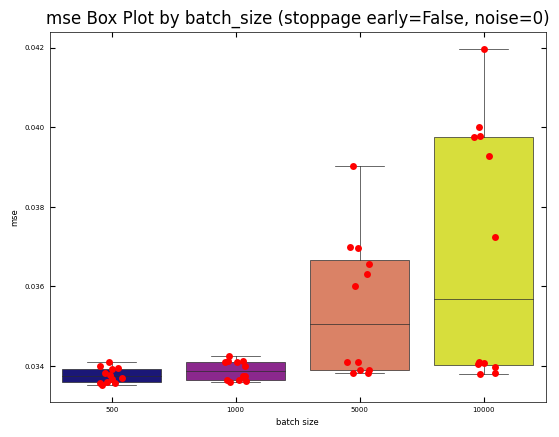

In [32]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'stoppage_early': False, "noise": 0}, 
                 x_column='batch_size', 
                 y_column='mse',
                 plot_type='boxplot')

## noise level: 1

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


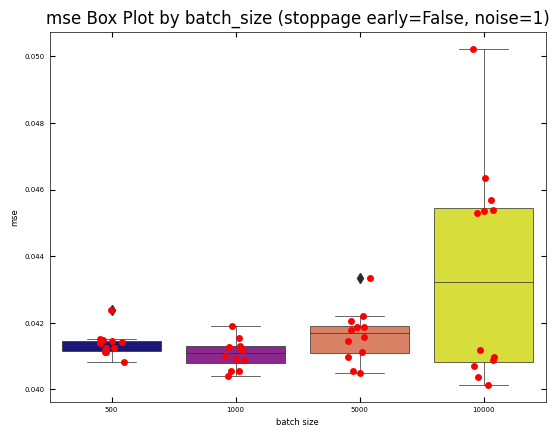

In [33]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'stoppage_early': False, "noise": 1}, 
                 x_column='batch_size', 
                 y_column='mse',
                 plot_type='boxplot')

## noise level: 2

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


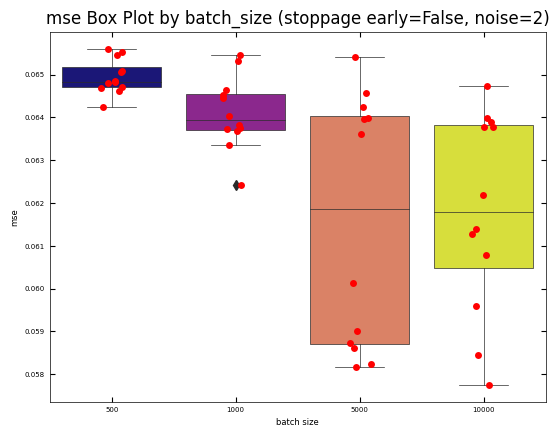

In [34]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'stoppage_early': False, "noise": 2}, 
                 x_column='batch_size', 
                 y_column='mse',
                 plot_type='boxplot')

## noise level: 3

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


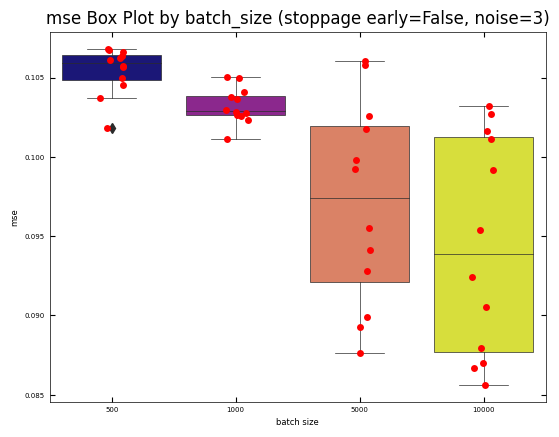

In [35]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'stoppage_early': False, "noise": 3}, 
                 x_column='batch_size', 
                 y_column='mse',
                 plot_type='boxplot')

## noise level: 4

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


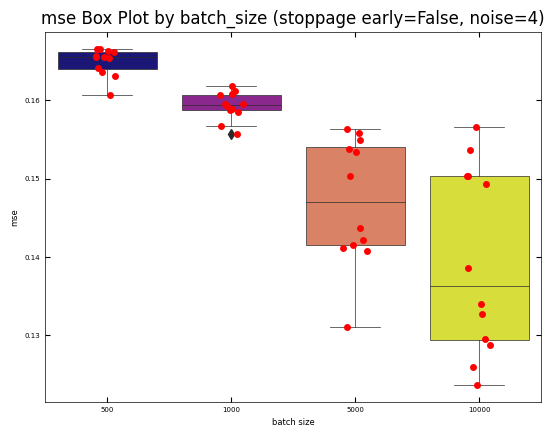

In [36]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'stoppage_early': False, "noise": 4}, 
                 x_column='batch_size', 
                 y_column='mse',
                 plot_type='boxplot')

## noise level: 5

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


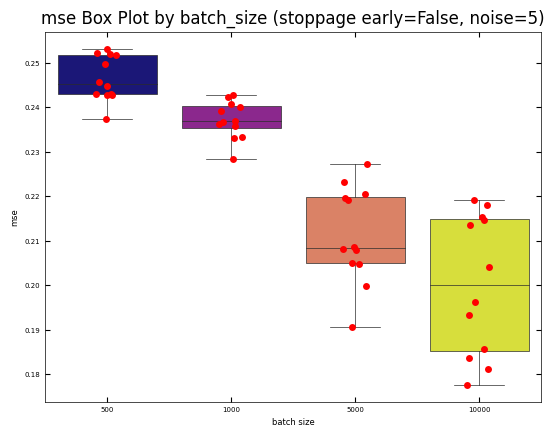

In [37]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'stoppage_early': False, "noise": 5}, 
                 x_column='batch_size', 
                 y_column='mse',
                 plot_type='boxplot')

## noise level: 6

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


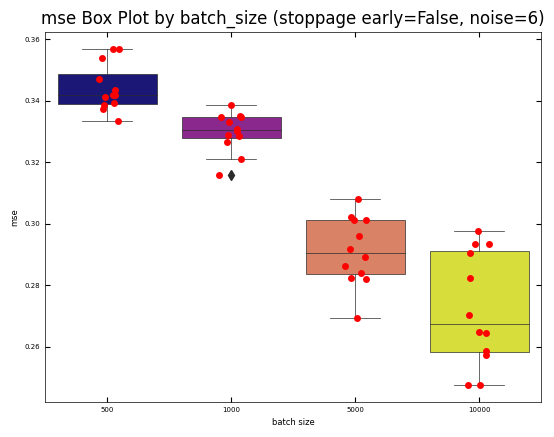

In [38]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'stoppage_early': False, "noise": 6}, 
                 x_column='batch_size', 
                 y_column='mse',
                 plot_type='boxplot')

## noise level: 7

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


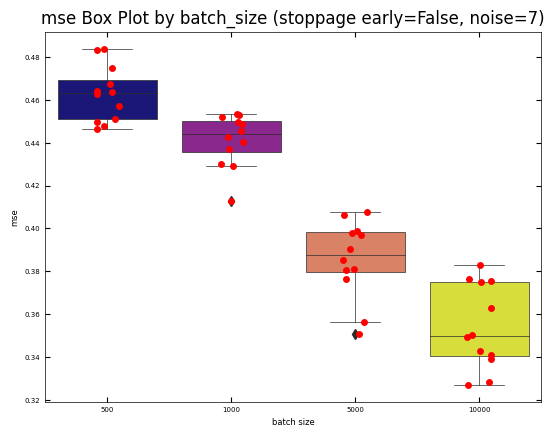

In [39]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'stoppage_early': False, "noise": 7}, 
                 x_column='batch_size', 
                 y_column='mse',
                 plot_type='boxplot')

## noise level: 8

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


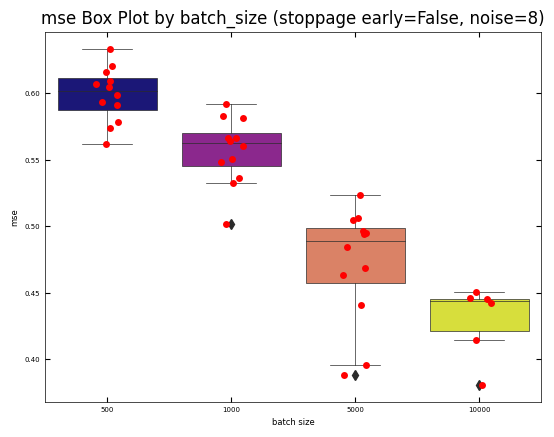

In [40]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'stoppage_early': False, "noise": 8}, 
                 x_column='batch_size', 
                 y_column='mse',
                 plot_type='boxplot')

# Box plot: MSE vs optimizer
## noise level: 0

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


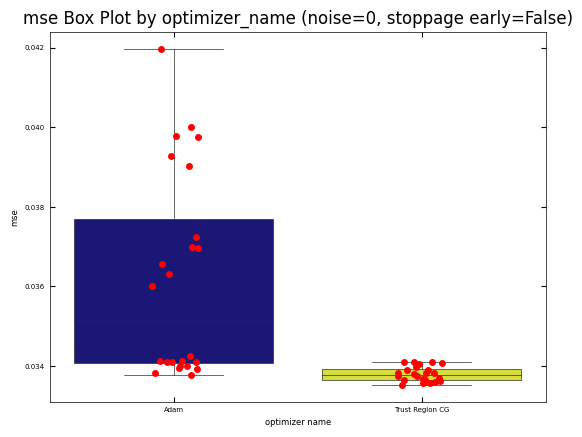

In [42]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 0, 'stoppage_early': False}, 
                 x_column='optimizer_name', 
                 y_column='mse')

## noise level: 1

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


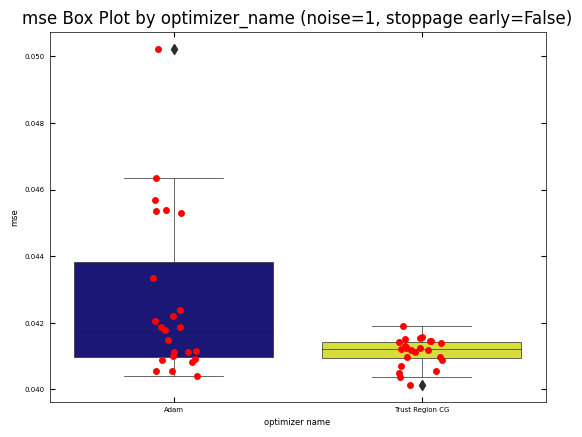

In [43]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 1, 'stoppage_early': False}, 
                 x_column='optimizer_name', 
                 y_column='mse')

## noise level: 2

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


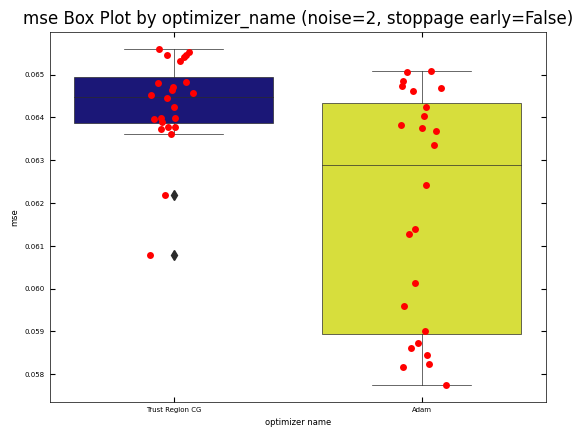

In [44]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 2, 'stoppage_early': False}, 
                 x_column='optimizer_name', 
                 y_column='mse')

## noise level: 3

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


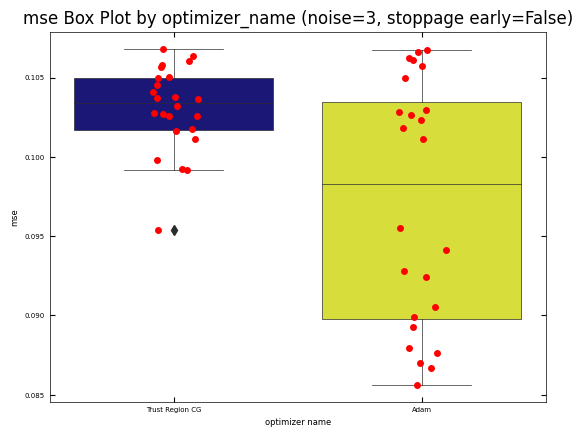

In [45]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 3, 'stoppage_early': False}, 
                 x_column='optimizer_name', 
                 y_column='mse')

## noise level: 4

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


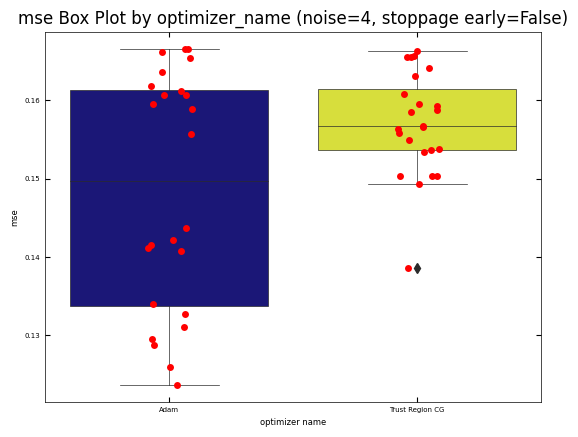

In [46]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 4, 'stoppage_early': False}, 
                 x_column='optimizer_name', 
                 y_column='mse')

## noise level: 5

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


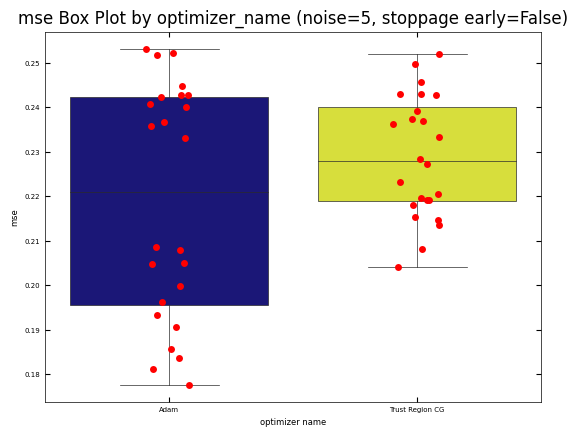

In [47]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 5, 'stoppage_early': False}, 
                 x_column='optimizer_name', 
                 y_column='mse')

## noise level: 6

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


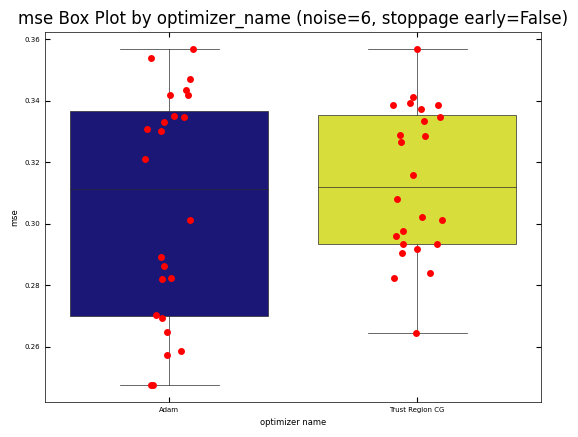

In [48]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 6, 'stoppage_early': False}, 
                 x_column='optimizer_name', 
                 y_column='mse')

## noise level: 7

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


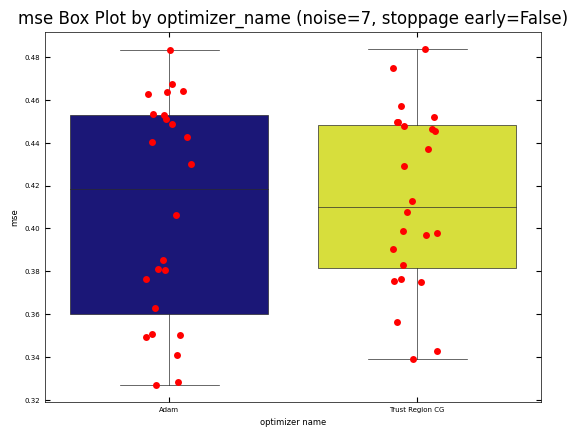

In [49]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 7, 'stoppage_early': False}, 
                 x_column='optimizer_name', 
                 y_column='mse')

## noise level: 8

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


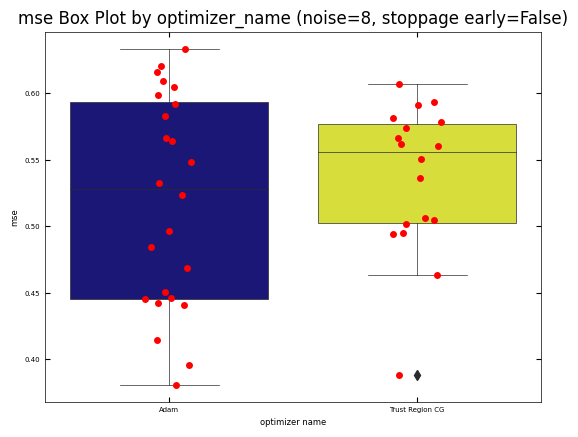

In [50]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 8, 'stoppage_early': False}, 
                 x_column='optimizer_name', 
                 y_column='mse')

# Scatter plot: MSE vs Training time
## Noise level:0

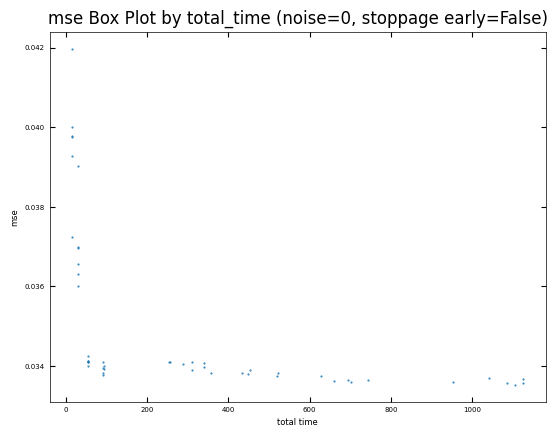

In [21]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 0, 'stoppage_early': False}, 
                 x_column='total_time', 
                 y_column='mse',
                 plot_type='scatter',
                 )

## Noise level:1

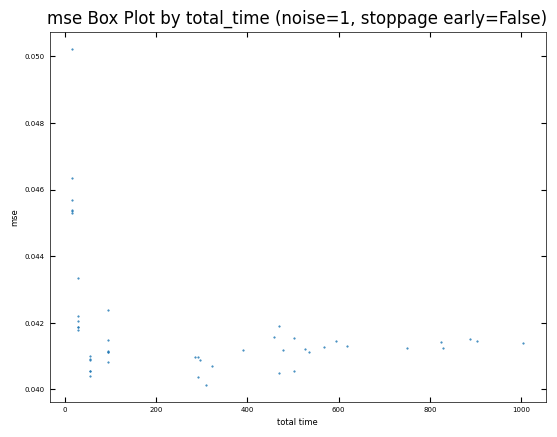

In [22]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 1, 'stoppage_early': False}, 
                 x_column='total_time', 
                 y_column='mse',
                 plot_type='scatter',
                 )

## Noise level:2

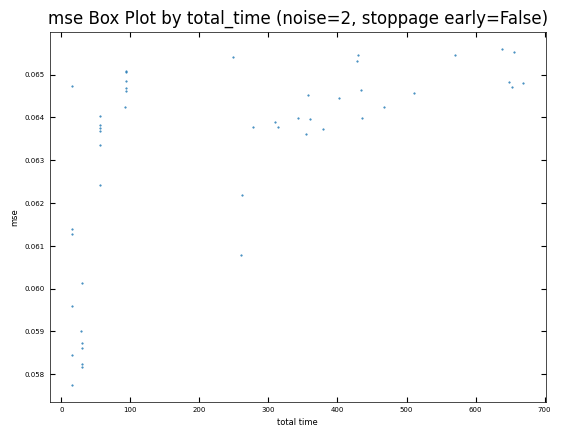

In [23]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 2, 'stoppage_early': False}, 
                 x_column='total_time', 
                 y_column='mse',
                 plot_type='scatter',
                 )

## Noise level:3

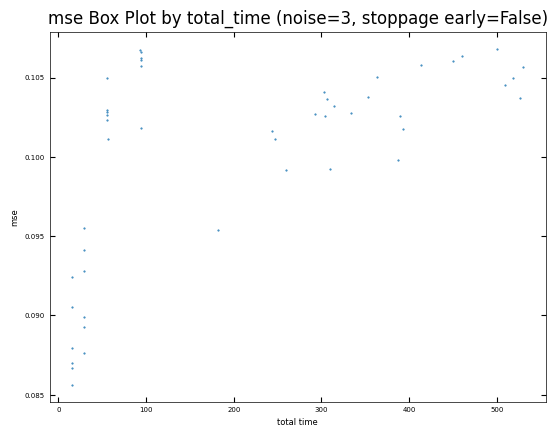

In [24]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 3, 'stoppage_early': False}, 
                 x_column='total_time', 
                 y_column='mse',
                 plot_type='scatter',
                 )

## Noise level:4

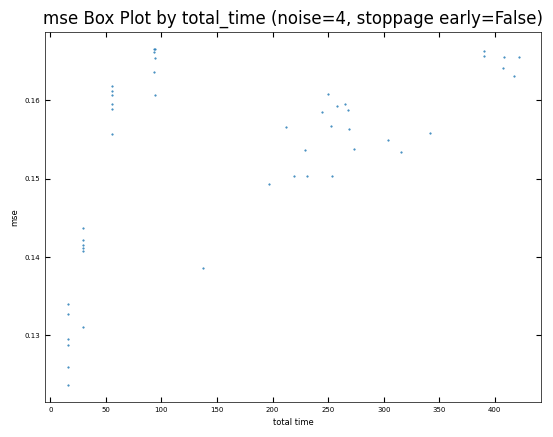

In [25]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 4, 'stoppage_early': False}, 
                 x_column='total_time', 
                 y_column='mse',
                 plot_type='scatter',
                 )

## Noise level:5

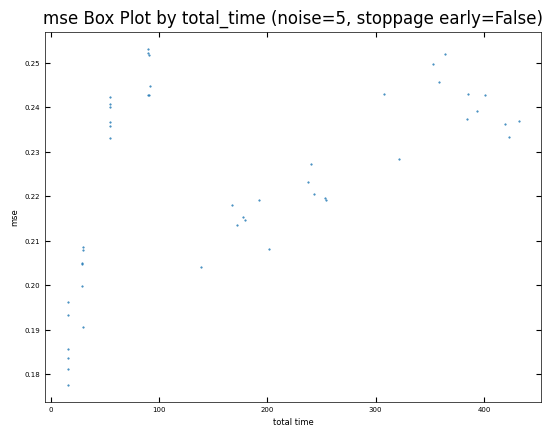

In [26]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 5, 'stoppage_early': False}, 
                 x_column='total_time', 
                 y_column='mse',
                 plot_type='scatter',
                 )

## Noise level:6

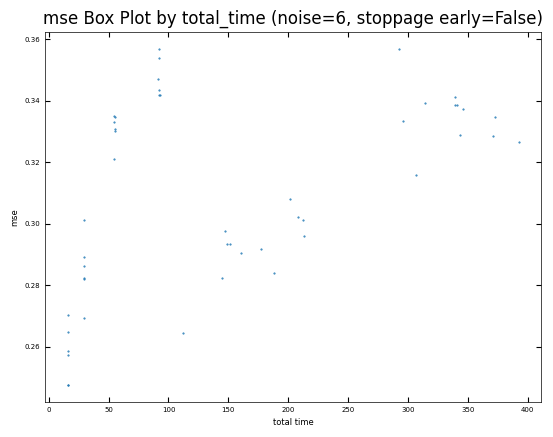

In [27]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 6, 'stoppage_early': False}, 
                 x_column='total_time', 
                 y_column='mse',
                 plot_type='scatter',
                 )

## Noise level:7

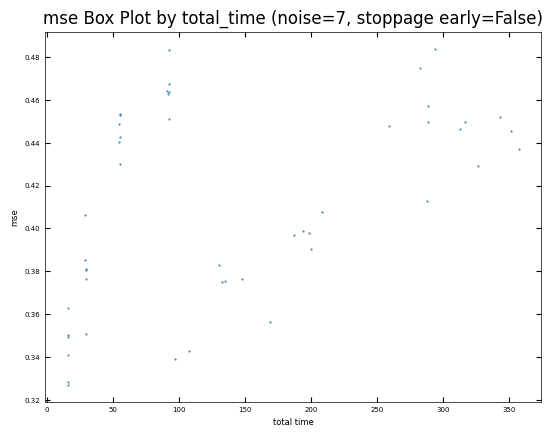

In [28]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 7, 'stoppage_early': False}, 
                 x_column='total_time', 
                 y_column='mse',
                 plot_type='scatter',
                 )

## Noise level:8

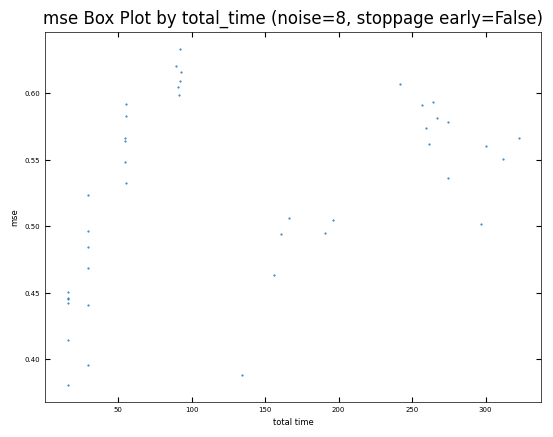

In [29]:
# Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 8, 'stoppage_early': False}, 
                 x_column='total_time', 
                 y_column='mse',
                 plot_type='scatter',
                 )

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


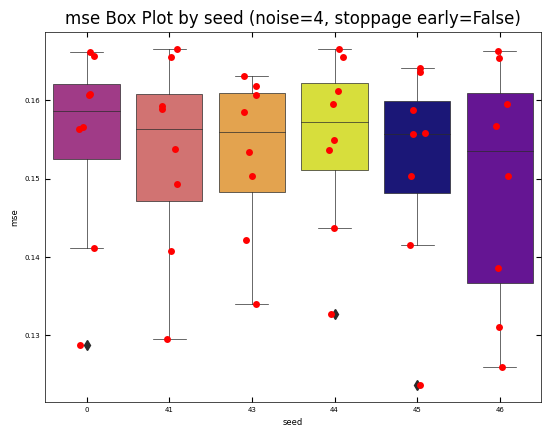

In [56]:
# # Using the function to plot with filters
flexible_boxplot(df, 
                 filters={'noise': 4, 'stoppage_early': False}, 
                 x_column='seed', 
                 y_column='mse')